In [3]:
import sys
import dotenv
import os
dotenv.load_dotenv()
sys.path.append(os.getenv('MAINDIR'))
from main import MoviesDatabase
import pandas as pd
import numpy as np

title = [movie.title for movie in MoviesDatabase.query.all()]
synopsis = [movie.description for movie in MoviesDatabase.query.all()]
collection = [movie.collection for movie in MoviesDatabase.query.all()]
genre = [movie.genre for movie in MoviesDatabase.query.all()]

In [4]:
from keybert import KeyBERT

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(synopsis, keyphrase_ngram_range=(1, 1), top_n=10)

/home/ksaff/miniconda3/envs/movie_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ksaff/miniconda3/envs/movie_env/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
keywords_words = []
keywords_values = []

for word_list in keywords:
    keywords_words.append([word[0] for word in word_list])
    keywords_values.append([word[1] for word in word_list])

In [6]:
df = pd.DataFrame({'title': title, 'synopsis': synopsis, 'collection': collection, 'genre': genre, 'keywords': keywords_words, 'keyvalues': keywords_values})

In [7]:
def get_namelist():
    baby_df = pd.read_csv('babynames.csv')
    namelist = set(baby_df['Name'])
    return namelist

def remove_names(keyword_list, namelist):
    return [word for word in keyword_list if word.capitalize() not in namelist]

namelist = get_namelist()
df['keywords'] = df['keywords'].apply(remove_names, args=(namelist,))

In [8]:
from nltk.stem import WordNetLemmatizer
import nltk

def lemmatize_keywords(keyword_list, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in keyword_list]

lemmatizer = WordNetLemmatizer()

df['keywords'] = df['keywords'].apply(lemmatize_keywords, args=(lemmatizer,))

In [9]:
import gensim.downloader

def delete_unrecognized_keywords(keyword_list, word2vec):
    new_keyword_list = []
    for word in keyword_list:
        try:
           word2vec[word]
           new_keyword_list.append(word)
        except KeyError:
            pass
    return new_keyword_list

wv = gensim.downloader.load('glove-wiki-gigaword-300')
df['keywords'] = df['keywords'].apply(delete_unrecognized_keywords, args=(wv,))

In [62]:
choosen_keywords = df[df['genre'] == 'Horror'].keywords.values
choosen_keywords = set([word for sublist in choosen_keywords for word in sublist])
choosen_keywords = [word for word in choosen_keywords if len(word) < 6]
choosen_keywords = choosen_keywords

In [96]:
my_keywords = ['monster']
parent_words = []
child_words = []
connection_value = []

for word_1 in my_keywords:
    for word_2 in choosen_keywords:
        if word_1 == word_2:
            continue
        similarity = wv.similarity(word_1, word_2)
        if similarity > 0.4:
            parent_words.append(word_1)
            child_words.append(word_2)
            connection_value.append(similarity)

In [97]:
my_keywords_2 = ['beast', 'devil', 'alien', 'hell', 'ghost', 'witch', 'scream', 'rage', 'vampire']

for word_1 in my_keywords_2[:]:
    for word_2 in choosen_keywords:
        if word_1 == word_2:
            continue
        similarity = wv.similarity(word_1, word_2)
        if similarity > 0.38:
            parent_words.append(word_1)
            child_words.append(word_2)
            connection_value.append(similarity)

In [98]:
new_set = set(parent_words + child_words)

for word_1 in new_set:
    for word_2 in new_set:
        if word_1 == word_2:
            continue
        similarity = wv.similarity(word_1, word_2)
        if similarity > 0.4:
            parent_words.append(word_1)
            child_words.append(word_2)
            connection_value.append(similarity)

In [99]:
# w2v_df = pd.DataFrame({'parent': parent_words, 'child': child_words, 'value': connection_value})
# w2v_df = w2v_df[w2v_df.groupby('parent')['parent'].transform('count') == 3]

# parent_words = w2v_df['parent'].values
# child_words = w2v_df['child'].values

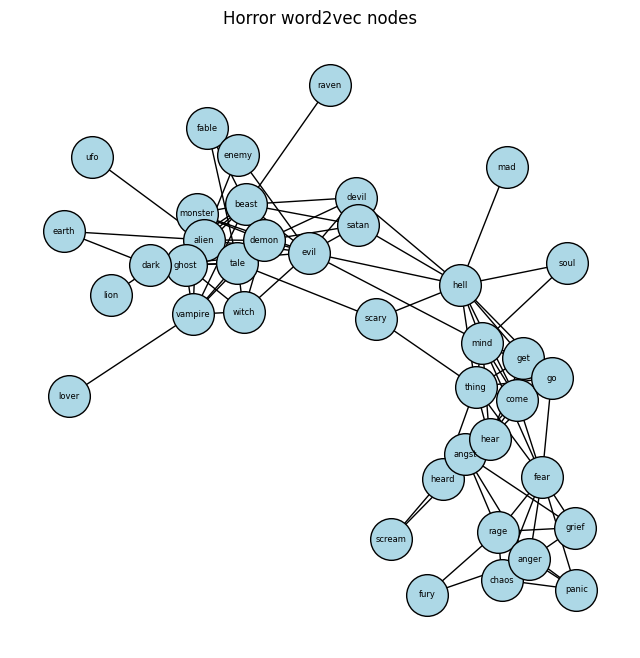

In [106]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
fig, ax = plt.subplots(figsize=(8, 8))


for word in parent_words:
    G.add_node(word)

edge_labels = {}
for i in range(len(parent_words)):
    parent = parent_words[i]
    child = child_words[i]
    G.add_edge(parent, child)
    edge_labels[(parent, child)] = ""

# Visualize the graph with edge labels
pos = nx.spring_layout(G, k=0.5, seed=12)
nx.draw(G, pos, with_labels=True, node_size=900, node_color="lightblue", font_size=6, edgecolors='black', alpha=1, edge_color='black')
plt.title('Horror word2vec nodes')

fig.set_facecolor('white')
plt.grid('on')
plt.show()
